# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='https://github.com/silviomori/udacity_deep_learning_pytorch_challenge/blob/master/assets/Flowers.png?raw=1' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
running_on_google_colab = True # False

# install required libraries
if running_on_google_colab:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

    !pip install Pillow==4.1.1

tcmalloc: large alloc 1073750016 bytes == 0x585f8000 @  0x7ff9a19862a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 5.7MB 6.5MB/s 
  Found existing installation: Pillow 5.3.0
    Uninstalling Pillow-5.3.0:
      Successfully uninstalled Pillow-5.3.0


In [0]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

from collections import OrderedDict

import numpy as np
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import Subset

import json
import time

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [3]:
data_dir = 'flower_data'

train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

# download data set
if running_on_google_colab:
    !wget https://raw.githubusercontent.com/udacity/pytorch_challenge/master/cat_to_name.json
    !wget https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
    !unzip flower_data.zip

--2018-11-25 19:02:54--  https://raw.githubusercontent.com/udacity/pytorch_challenge/master/cat_to_name.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2218 (2.2K) [text/plain]
Saving to: ‘cat_to_name.json’

cat_to_name.json    100%[===================>]   2.17K  --.-KB/s    in 0s      

2018-11-25 19:02:54 (42.6 MB/s) - ‘cat_to_name.json’ saved [2218/2218]

--2018-11-25 19:02:55--  https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.96.13
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.96.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 311442766 (297M) [application/zip]
Saving to: ‘flower_data.zip’

flower_data.zip     100%[=============

In [4]:
# Define your transforms for the training and validation sets

# arrays to normalization
normalize_mean = np.array([0.485, 0.456, 0.406])
normalize_std = np.array([0.229, 0.224, 0.225])

data_transforms = {}

# transforms to train data set
data_transforms['train'] = transforms.Compose([
    transforms.RandomChoice([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(180),
        ]),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        normalize_mean,
        normalize_std)
    ])

# transforms to valid data set
data_transforms['valid'] = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        normalize_mean,
        normalize_std)
    ])

# Load the datasets with ImageFolder
image_datasets = {}
image_datasets['train_data'] = datasets.ImageFolder(data_dir + '/train', transform=data_transforms['train'])
valid_dataset_to_split = datasets.ImageFolder(data_dir + '/valid', transform=data_transforms['valid'])


# obtain validation and training datasets that will be used to evaluate the network
valid_data_index_list = []
test_data_index_list = []
for index in range(0, len(valid_dataset_to_split), 2):
    valid_data_index_list.append(index)
    test_data_index_list.append(index+1)

image_datasets['valid_data'] = Subset(valid_dataset_to_split, valid_data_index_list)
image_datasets['test_data'] = Subset(valid_dataset_to_split, test_data_index_list)

# Using the image datasets and the transforms, define the dataloaders
dataloaders = {}
dataloaders['train_data'] = torch.utils.data.DataLoader(image_datasets['train_data'], batch_size=32, shuffle=True, num_workers=32)
dataloaders['valid_data'] = torch.utils.data.DataLoader(image_datasets['valid_data'], batch_size=23, shuffle=False, num_workers=32)
dataloaders['test_data'] = torch.utils.data.DataLoader(image_datasets['test_data'], batch_size=23, shuffle=False, num_workers=32)
print(f"Train data: {len(dataloaders['train_data'].dataset)} images / {len(dataloaders['train_data'])} batches")
print(f"Valid data: {len(dataloaders['valid_data'].dataset)} images / {len(dataloaders['valid_data'])} batches")
print(f"Test  data: {len(dataloaders['test_data'].dataset)} images / {len(dataloaders['test_data'])} batches") 

Train data: 6552 images / 205 batches
Valid data: 409 images / 18 batches
Test  data: 409 images / 18 batches


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [5]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

class_to_idx = image_datasets['train_data'].class_to_idx

cat_label_to_name = {}
for cat, label in class_to_idx.items():
    name = cat_to_name.get(cat)
    cat_label_to_name[label] = name

print(cat_label_to_name)

{0: 'pink primrose', 1: 'globe thistle', 2: 'blanket flower', 3: 'trumpet creeper', 4: 'blackberry lily', 5: 'snapdragon', 6: "colt's foot", 7: 'king protea', 8: 'spear thistle', 9: 'yellow iris', 10: 'globe-flower', 11: 'purple coneflower', 12: 'peruvian lily', 13: 'balloon flower', 14: 'hard-leaved pocket orchid', 15: 'giant white arum lily', 16: 'fire lily', 17: 'pincushion flower', 18: 'fritillary', 19: 'red ginger', 20: 'grape hyacinth', 21: 'corn poppy', 22: 'prince of wales feathers', 23: 'stemless gentian', 24: 'artichoke', 25: 'canterbury bells', 26: 'sweet william', 27: 'carnation', 28: 'garden phlox', 29: 'love in the mist', 30: 'mexican aster', 31: 'alpine sea holly', 32: 'ruby-lipped cattleya', 33: 'cape flower', 34: 'great masterwort', 35: 'siam tulip', 36: 'sweet pea', 37: 'lenten rose', 38: 'barbeton daisy', 39: 'daffodil', 40: 'sword lily', 41: 'poinsettia', 42: 'bolero deep blue', 43: 'wallflower', 44: 'marigold', 45: 'buttercup', 46: 'oxeye daisy', 47: 'english marig

In [0]:
def imgview(img, title, ax):
    # un-normalize
    for i in range(img.shape[0]):
        img[i] = img[i] * normalize_std[i] + normalize_mean[i]
    
    # convert from Tensor image
    ax.imshow(np.transpose(img, (1, 2, 0)))

    ax.set_title(title)

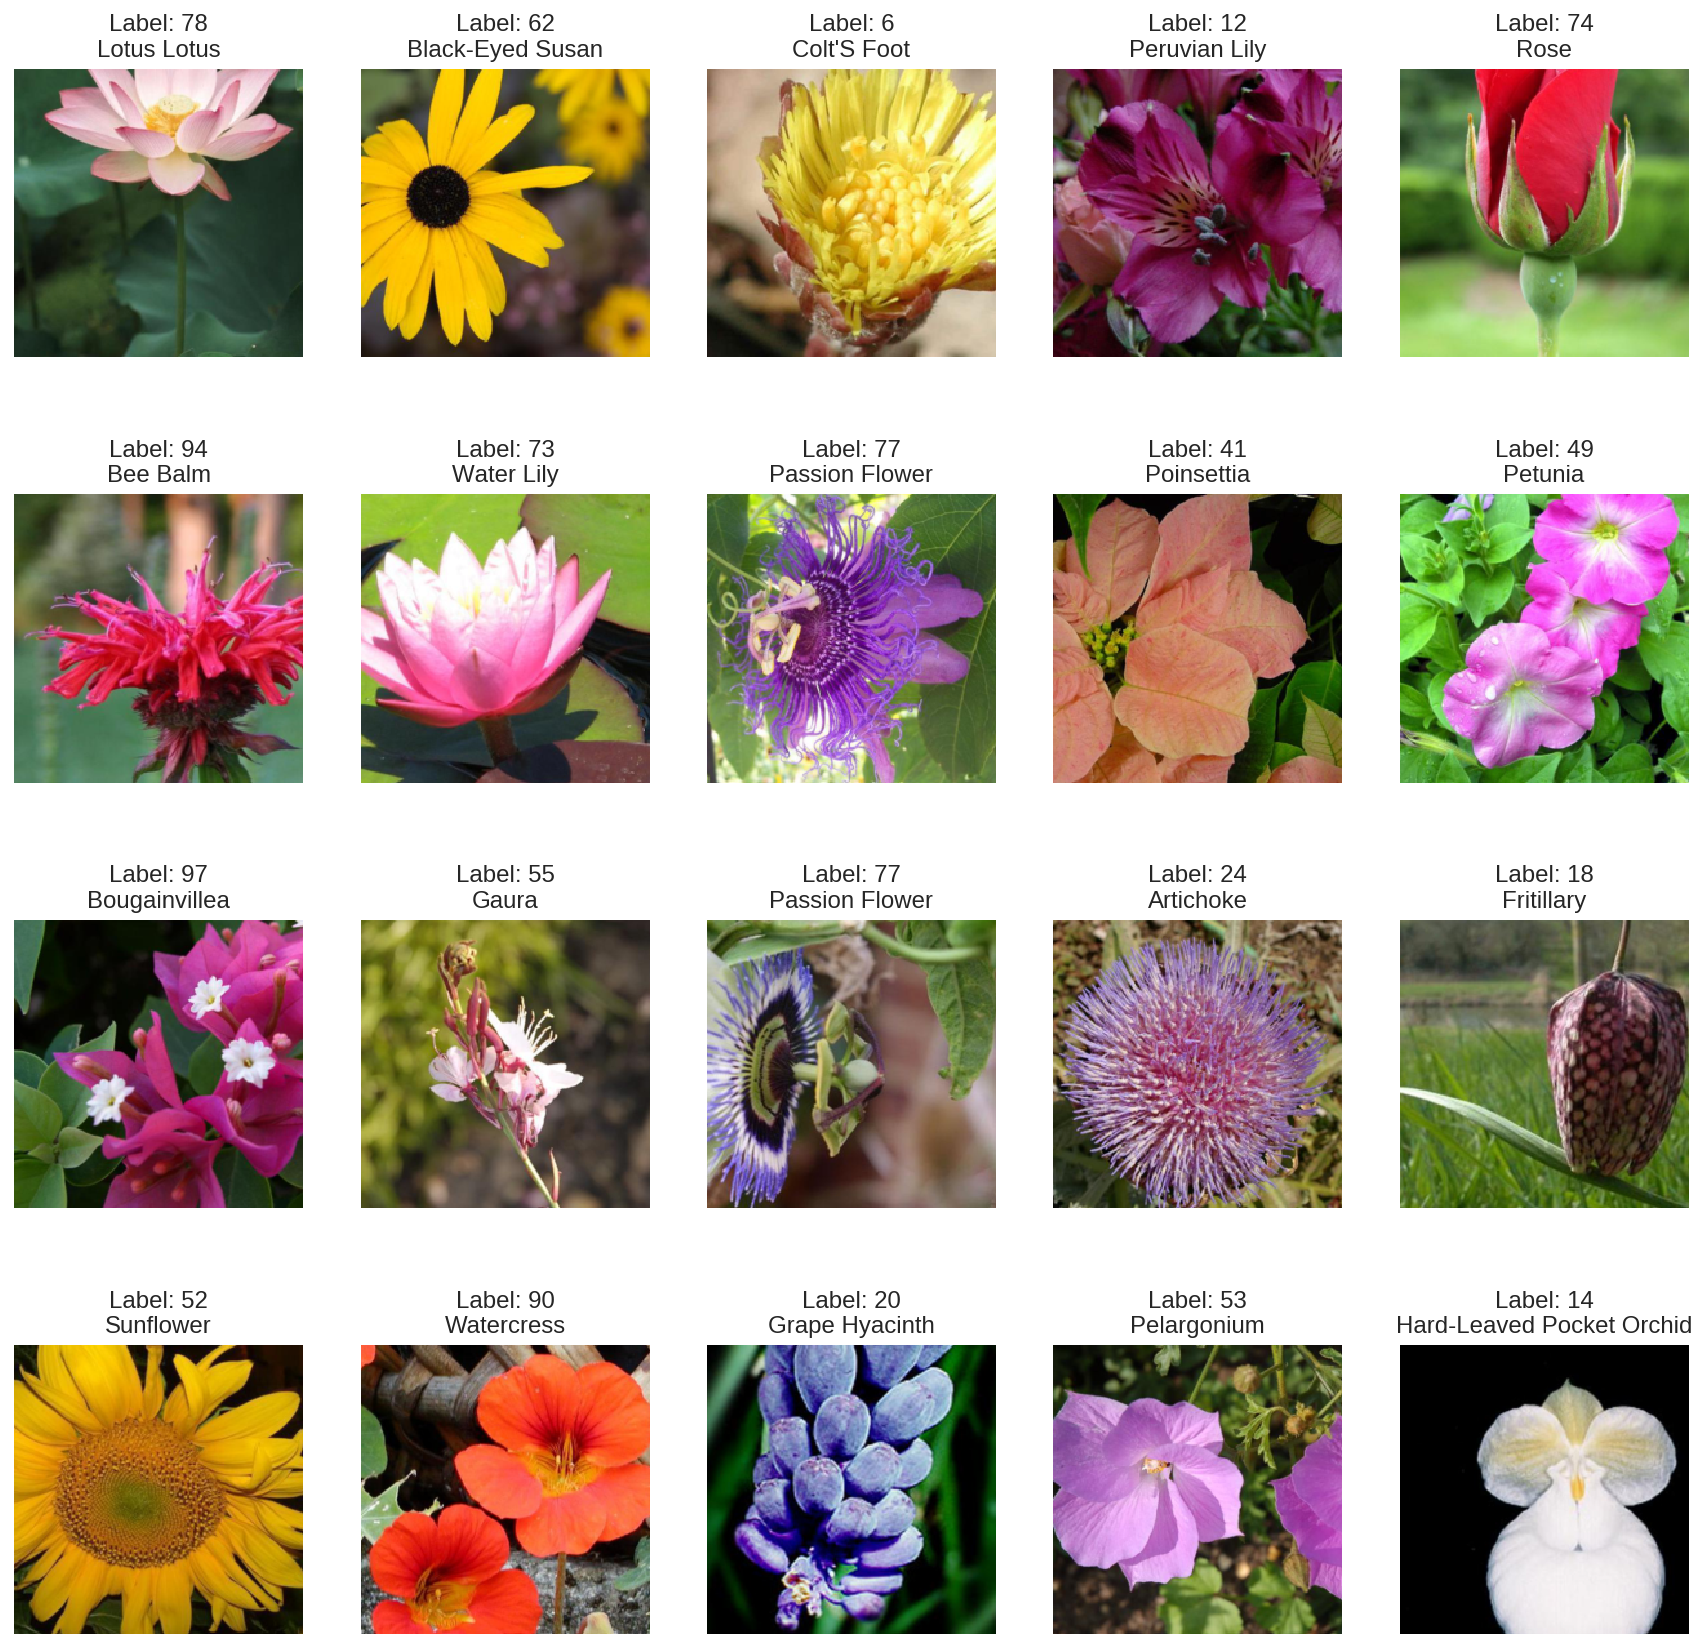

In [7]:
# obtain one batch of training images
dataiter = iter(dataloaders['train_data'])
images, labels = dataiter.next()

images = images.numpy() # convert images to numpy for display

# show some test images
fig = plt.figure(figsize=(15, 15))
fig_rows, fig_cols = 4, 5
for index in np.arange(fig_rows*fig_cols):

    img = images[index]

    label = labels[index].item()
    title = f'Label: {label}\n{cat_label_to_name[label].title()}'

    ax = fig.add_subplot(fig_rows, fig_cols, index+1, xticks=[], yticks=[])

    imgview(img, title, ax)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [0]:
# Freeze parameters so we don't backprop through them
def freeze_parameters(root, freeze=True):
    [param.requires_grad_(not freeze) for param in root.parameters()]

In [0]:
# Create a new classifier
def create_classifier(input_size, output_size, hidden_layers=[], dropout=0.5,
                      activation=nn.RReLU(), output_function=nn.LogSoftmax(dim=1)):
    dict = OrderedDict()
    
    if len(hidden_layers) == 0:
        dict['layer0'] = nn.Linear(input_size, output_size)

    else:
        
        dict['layer0'] = nn.Linear(input_size, hidden_layers[0])
        if activation:
            dict['activ0'] = activation
        if dropout:
            dict['drop_0'] = nn.Dropout(dropout)
        
        #for layer_in, layer_out in range(len(hidden_layers)):
        for layer, layer_in in enumerate(zip(hidden_layers[:-1],hidden_layers[1:])):
            dict['layer'+str(layer+1)] = nn.Linear(layer_in[0],layer_in[1])
            if activation:
                dict['activ'+str(layer+1)] = activation
            if dropout:
                dict['drop_'+str(layer+1)] = nn.Dropout(dropout)
            
        dict['output'] = nn.Linear(hidden_layers[-1], output_size)

    if output_function:
        dict['output_function'] = output_function
    
    return nn.Sequential(dict)

In [0]:
# Build and train your network
def create_network(model_name='resnet50', output_size=102, hidden_layers=[1000]):
    if model_name == 'resnet50':
        # Download the model
        model = models.resnet50(pretrained=True)
        # Replace the model classifier
        model.fc = create_classifier(2048, output_size, hidden_layers)
        
        return model
        
    if model_name == 'resnet152':
        # Download the model
        model = models.resnet152(pretrained=True)
        # Replace the model classifier
        model.fc = create_classifier(2048, output_size, hidden_layers)
        
        return model
        
    return None

In [11]:
# Define hyperparameters
model_name = 'resnet50'
output_size = 102
hidden_layers = [1000]

model = create_network(model_name, output_size, hidden_layers)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:03<00:00, 33240095.08it/s]


In [12]:
# check if CUDA is available
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
model.to(device)

print(f'Running on: {str(device).upper()}')

Running on: CUDA


In [0]:
def train(epochs, model, optimizers, lr_scheduler=None,
          dataloaders=dataloaders, state_dict=None,
          checkpoint_path="checkpoint.pt", accuracy_target=None,
          show_graphs=True):

    if state_dict == None:
        state_dict = {
            'elapsed_time': 0,
            'trace_log': [],
            'trace_train_loss': [],
            'trace_train_lr': [],
            'valid_loss_min': np.Inf,
            'trace_valid_loss': [],
            'trace_accuracy': [],
            'epochs_trained': 0}
        state_dict['trace_log'].append('PHASE ONE')


    for epoch in range(1,epochs+1):
        
        try:
            lr_scheduler.step() # if instance of _LRScheduler
        except TypeError:
            try:
                if lr_scheduler.min_lrs[0] == lr_scheduler.optimizer.param_groups[0]['lr']:
                    break
                lr_scheduler.step(valid_loss) # if instance of ReduceLROnPlateau
            except NameError: # valid_loss is not defined yet
                lr_scheduler.step(0)
        except:
            pass # do nothing

        epoch_start_time = time.time()
        #####################
        #       TRAIN       #
        #####################
        train_loss = 0
        model.train()
        for images, labels in dataloaders['train_data']:
            # Move tensors to device
            images, labels = images.to(device), labels.to(device)

            # Clear optimizers
            [opt.zero_grad() for opt in optimizers]

            # Pass train batch through model feed-forward
            output = model(images)

            # Calculate loss for this train batch
            batch_loss = criterion(output, labels)
            # Do the backpropagation
            batch_loss.backward()

            # Optimize parameters
            [opt.step() for opt in optimizers]

            # Track train loss
            train_loss += batch_loss.item()*len(images)

        # Track how many epochs has already run
        state_dict['elapsed_time'] += time.time()-epoch_start_time
        state_dict['epochs_trained'] += 1

        #####################
        #      VALIDATE     #
        #####################
        valid_loss = 0
        accuracy = 0
        top_class_graph = []
        labels_graph = []
        # Set model to evaluation mode
        model.eval()
        with torch.no_grad():
            for images, labels in dataloaders['valid_data']:
                labels_graph.extend( labels )

                # Move tensors to device
                images, labels = images.to(device), labels.to(device)

                # Get predictions for this validation batch
                output = model(images)

                # Calculate loss for this validation batch
                batch_loss = criterion(output, labels)
                # Track validation loss
                valid_loss += batch_loss.item()*len(images)

                # Calculate accuracy
                output = torch.exp(output)
                top_ps, top_class = output.topk(1, dim=1)
                top_class_graph.extend( top_class.view(-1).to('cpu').numpy() )
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()*len(images)

        #####################
        #     PRINT LOG     #
        #####################
        
        # calculate average losses
        train_loss = train_loss/len(dataloaders['train_data'].dataset)
        valid_loss = valid_loss/len(dataloaders['valid_data'].dataset)
        accuracy = accuracy/len(dataloaders['valid_data'].dataset)

        state_dict['trace_train_loss'].append(train_loss)
        try:
            state_dict['trace_train_lr'].append(lr_scheduler.get_lr()[0])
        except:
            state_dict['trace_train_lr'].append(
                optimizers[0].state_dict()['param_groups'][0]['lr'])
        state_dict['trace_valid_loss'].append(valid_loss)
        state_dict['trace_accuracy'].append(accuracy)

        # print training/validation statistics 
        log = 'Epoch: {}: \
               lr: {:.8f}\t\
               Training Loss: {:.6f}\t\
               Validation Loss: {:.6f}\t\
               Validation accuracy: {:.2f}%\t\
               Elapsed time: {:.2f}'.format(
                    state_dict['epochs_trained'],
                    state_dict['trace_train_lr'][-1],
                    train_loss,
                    valid_loss,
                    accuracy*100,
                    state_dict['elapsed_time']
                    )
        state_dict['trace_log'].append(log)
        print(log)

        # save model if validation loss has decreased
        if valid_loss <= state_dict['valid_loss_min']:
            print('Validation loss decreased: \
                  ({:.6f} --> {:.6f}).   Saving model ...'
                  .format(state_dict['valid_loss_min'],valid_loss))

            checkpoint = {'model_state_dict': model.state_dict(),
                          'optimizer_state_dict': optimizers[0].state_dict(),
                          'training_state_dict': state_dict}
            if lr_scheduler:
                checkpoint['lr_scheduler_state_dict'] = lr_scheduler.state_dict()

            torch.save(checkpoint, checkpoint_path)
            state_dict['valid_loss_min'] = valid_loss

        if show_graphs:
            plt.figure(figsize=(25,8))
            plt.plot(np.array(labels_graph), 'k.')
            plt.plot(np.array(top_class_graph), 'r.')
            plt.show()

            plt.figure(figsize=(25,5))
            plt.subplot(1,2,1)
            plt.plot(np.array(state_dict['trace_train_loss']), 'b', label='train loss')
            plt.plot(np.array(state_dict['trace_valid_loss']), 'r', label='validation loss')
            plt.plot(np.array(state_dict['trace_accuracy']), 'g', label='accuracy')

            plt.subplot(1,2,2)
            plt.plot(np.array(state_dict['trace_train_lr']), 'b', label='train loss')

            plt.show()


        # stop training loop if accuracy_target has been reached
        if accuracy_target and state_dict['trace_accuracy'][-1] >= accuracy_target:
            break

    return state_dict

In [0]:
def test_model(dataloader=dataloaders['test_data'], show_graphs=True):
    #####################
    #       TEST        #
    #####################
    criterion = nn.NLLLoss()
    test_loss = 0
    accuracy = 0
    top_class_graph = []
    labels_graph = []
    # Set model to evaluation mode
    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            labels_graph.extend( labels )

            # Move tensors to device
            images, labels = images.to(device), labels.to(device)

            # Get predictions for this test batch
            output = model(images)

            # Calculate loss for this test batch
            batch_loss = criterion(output, labels)
            # Track validation loss
            test_loss += batch_loss.item()*len(images)

            # Calculate accuracy
            output = torch.exp(output)
            top_ps, top_class = output.topk(1, dim=1)
            top_class_graph.extend( top_class.view(-1).to('cpu').numpy() )
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.sum(equals.type(torch.FloatTensor)).item()

    #####################
    #     PRINT LOG     #
    #####################

    # calculate average losses
    test_loss = test_loss/len(dataloader.dataset)
    accuracy = accuracy/len(dataloader.dataset)

    # print training/validation statistics 
    log = f'Test Loss: {test_loss:.6f}\t\
           Test accuracy: {(accuracy*100):.2f}%'
    print(log)

    if show_graphs:
        plt.figure(figsize=(25,13))
        plt.plot(np.array(labels_graph), 'k.')
        plt.plot(np.array(top_class_graph), 'r.')
        plt.show()

        plt.show()

In [0]:
def load_model(checkpoint_path, state_dict):
    try:
        checkpoint = torch.load(checkpoint_path)
        state_dict = checkpoint['training_state_dict']
        model.load_state_dict(checkpoint['model_state_dict'])
        fc_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    except FileNotFoundError:
        pass

    return state_dict
    

Epoch: 65:                lr: 0.00010000	               Training Loss: 0.290326	               Validation Loss: 0.190181	               Validation accuracy: 95.11%	               Elapsed time: 5069.34


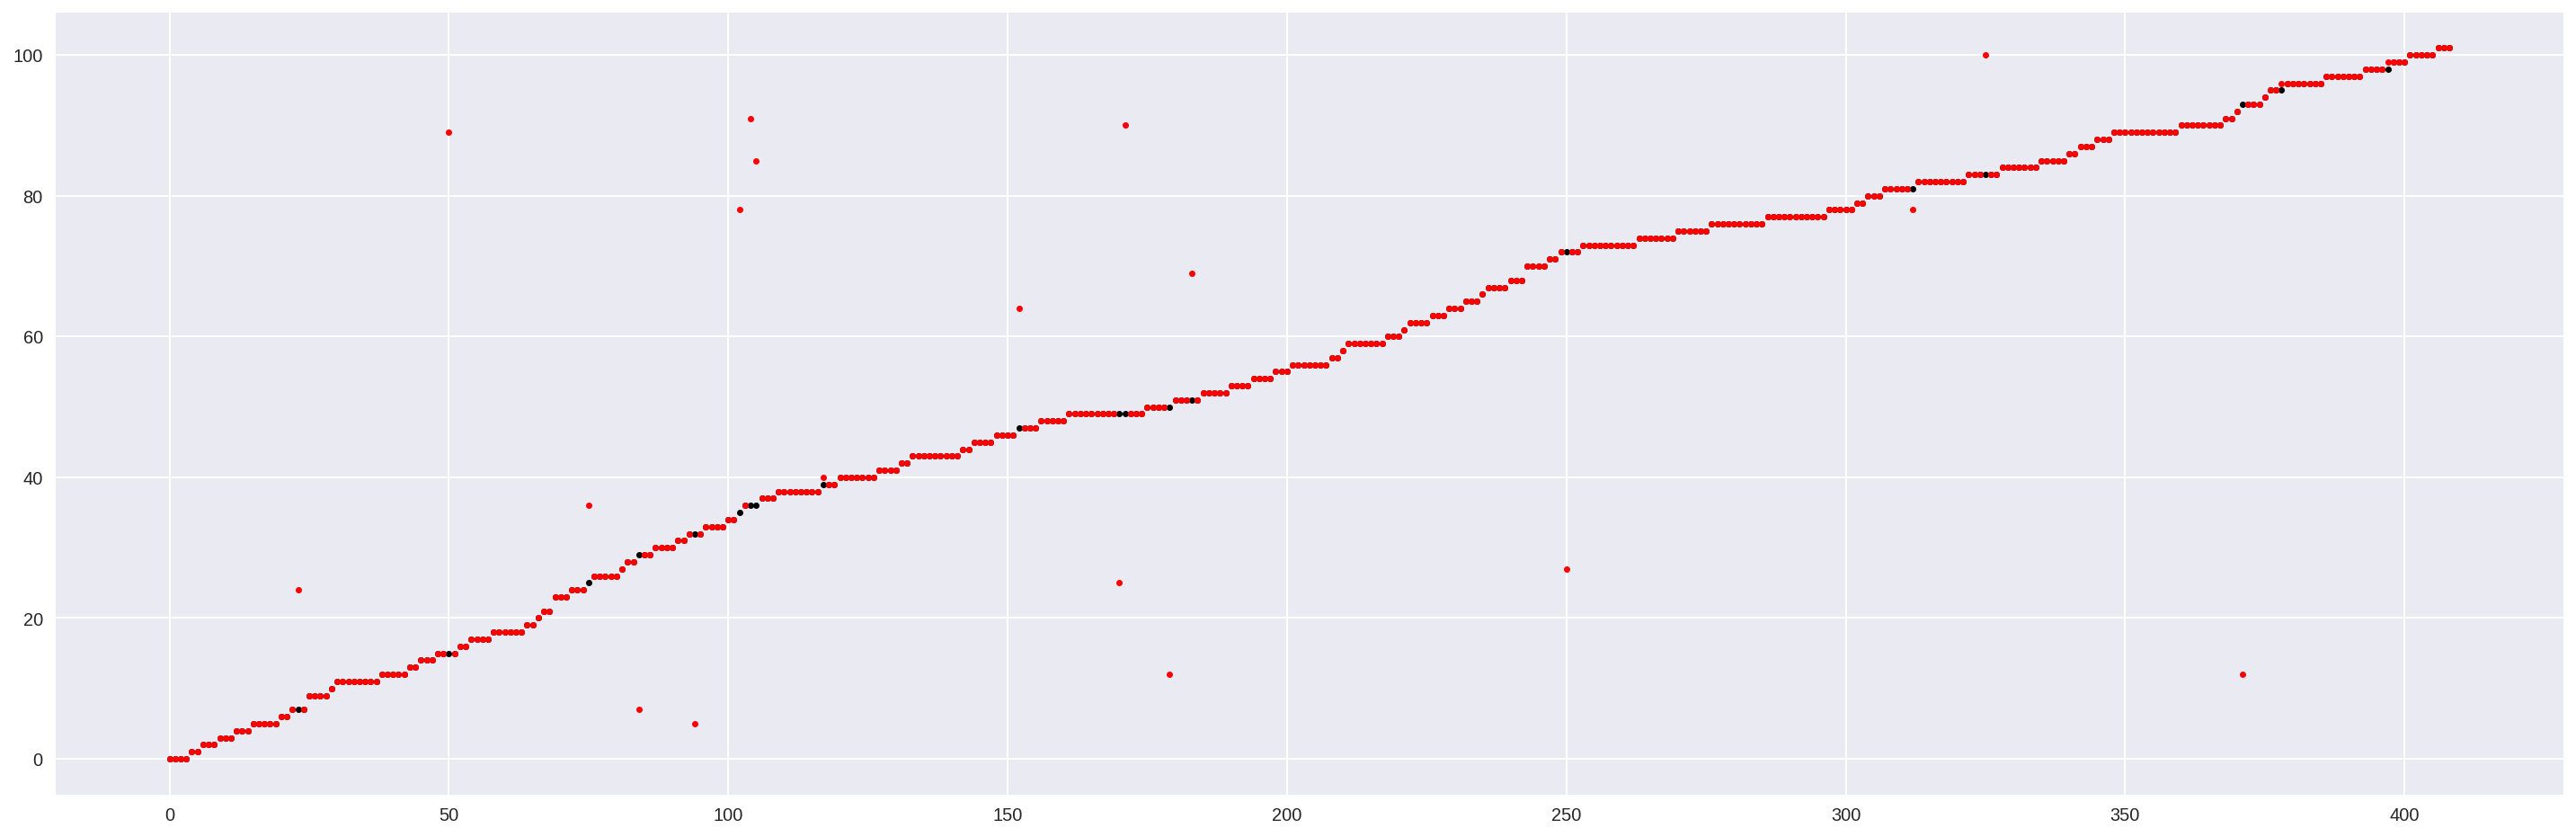

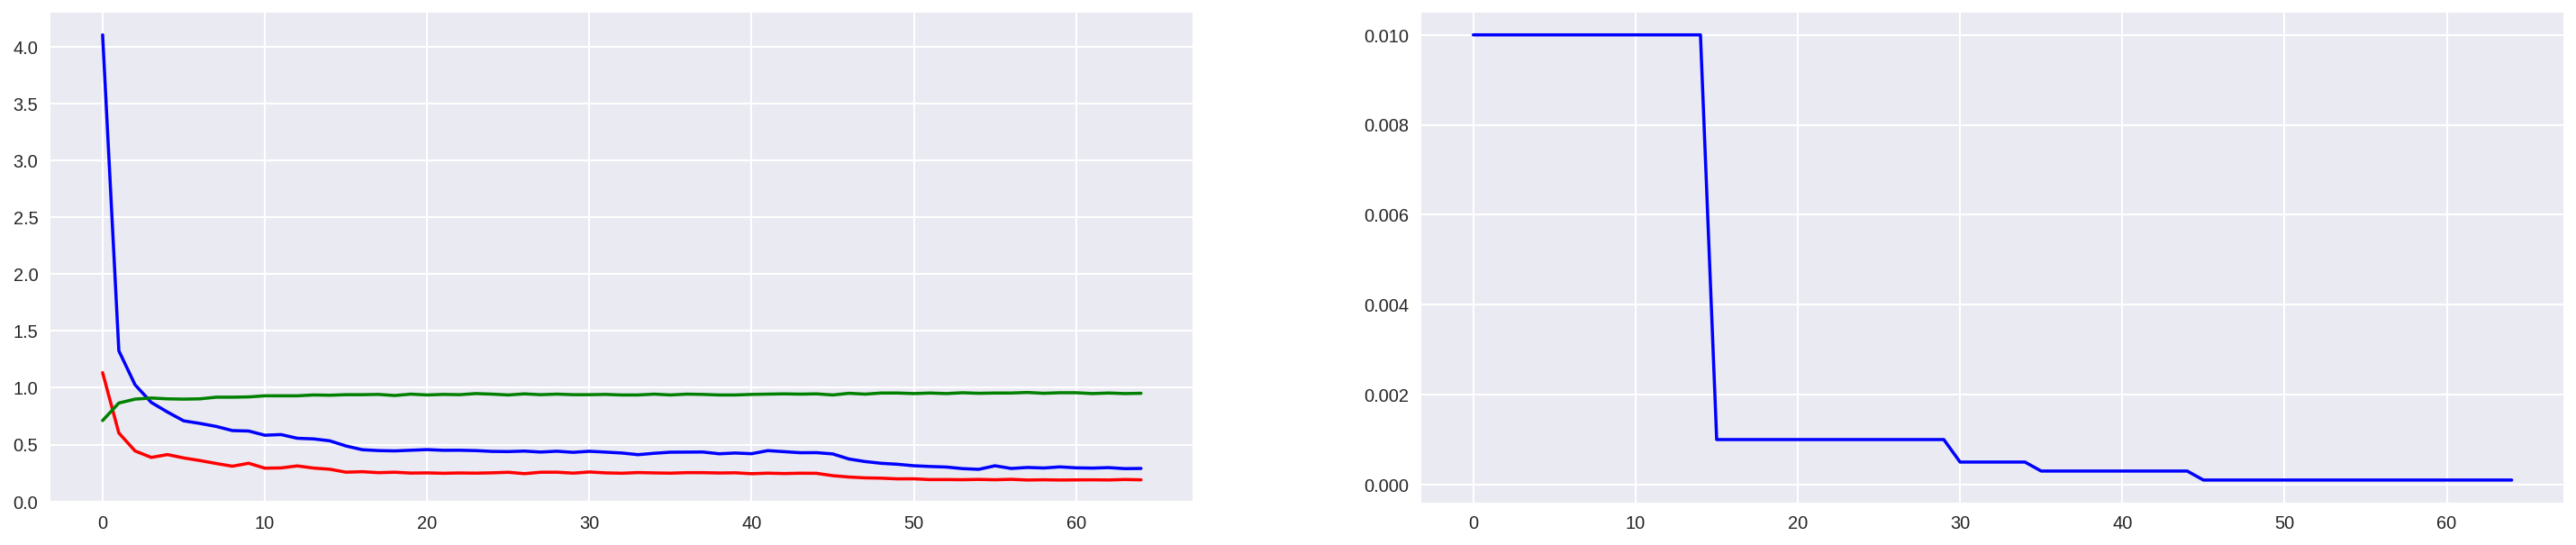

PHASE SIX RESULTS: 
Epoch: 1:                lr: 0.01000000	               Training Loss: 4.102769	               Validation Loss: 1.132713	               Validation accuracy: 71.15%	               Elapsed time: 75.92
Epoch: 2:                lr: 0.01000000	               Training Loss: 1.325422	               Validation Loss: 0.602294	               Validation accuracy: 86.55%	               Elapsed time: 149.61
Epoch: 3:                lr: 0.01000000	               Training Loss: 1.025663	               Validation Loss: 0.444294	               Validation accuracy: 89.98%	               Elapsed time: 226.38
Epoch: 4:                lr: 0.01000000	               Training Loss: 0.870814	               Validation Loss: 0.387141	               Validation accuracy: 90.95%	               Elapsed time: 301.93
Epoch: 5:                lr: 0.01000000	               Training Loss: 0.786087	               Validation Loss: 0.412155	               Validation accuracy: 90.22%	               Elapsed

In [18]:
# Training strategy

# Define a loss function
criterion = nn.NLLLoss() # Cross-Entropy (LogSoftmax and NLLLoss)

# Define how many times each phase will be running
PHASE_ONE = 15
PHASE_TWO = 15
PHASE_THREE = 5
PHASE_FOUR = 10
PHASE_FIVE = 10
PHASE_SIX = 10

TEST = True

# Define the phases
if PHASE_ONE > 0:
    freeze_parameters(model, True)
    freeze_parameters(model.fc, False)

    fc_optimizer = optim.Adagrad(model.fc.parameters(), lr=0.01, weight_decay=0.001)
    optimizers = [fc_optimizer]

    checkpoint_path="checkpoint_phase_one.pt"
    
    state_dict = train(PHASE_ONE, model, optimizers, lr_scheduler=None,
                       state_dict=None, accuracy_target=None,
                       checkpoint_path=checkpoint_path)

    print(*state_dict['trace_log'], sep="\n")
    
    state_dict = load_model(checkpoint_path, state_dict)

if PHASE_TWO > 0:
    state_dict['trace_log'].append('PHASE TWO')
    
    freeze_parameters(model, True)
    freeze_parameters(model.fc, False)

    lr_scheduler = optim.lr_scheduler.MultiStepLR(fc_optimizer, milestones=[0], gamma=0.1)
    
    checkpoint_path="checkpoint_phase_two.pt"
    
    state_dict = train(PHASE_TWO, model, optimizers, lr_scheduler=lr_scheduler,
                       state_dict=state_dict, accuracy_target=None,
                       checkpoint_path=checkpoint_path)

    print(*state_dict['trace_log'], sep="\n")
    
    state_dict = load_model(checkpoint_path, state_dict)


if PHASE_THREE > 0:
    state_dict['trace_log'].append('PHASE THREE')

    freeze_parameters(model, True)
    freeze_parameters(model.fc, False)

    lr_scheduler = optim.lr_scheduler.MultiStepLR(fc_optimizer, milestones=[0], gamma=0.05)
    
    checkpoint_path="checkpoint_phase_three.pt"
    
    state_dict = train(PHASE_THREE, model, optimizers, lr_scheduler=lr_scheduler,
                       state_dict=state_dict, accuracy_target=None,
                       checkpoint_path=checkpoint_path)

    print(*state_dict['trace_log'], sep="\n")

    state_dict = load_model(checkpoint_path, state_dict)

if PHASE_FOUR > 0:
    state_dict['trace_log'].append('PHASE FOUR')

    freeze_parameters(model, True)
    freeze_parameters(model.fc, False)

    lr_scheduler = optim.lr_scheduler.MultiStepLR(fc_optimizer, milestones=[0], gamma=0.03)
    
    checkpoint_path="checkpoint_phase_four.pt"
    
    state_dict = train(PHASE_FOUR, model, optimizers, lr_scheduler=lr_scheduler,
                       state_dict=state_dict, accuracy_target=None,
                       checkpoint_path=checkpoint_path)

    print(*state_dict['trace_log'], sep="\n")

    state_dict = load_model(checkpoint_path, state_dict)

if PHASE_FIVE > 0:
    state_dict['trace_log'].append('PHASE FIVE')

    freeze_parameters(model, True)
    freeze_parameters(model.layer4, False)

    conv_optimizer = optim.Adagrad(model.layer4.parameters(), lr=0.0001,
                             weight_decay=0.001)
    optimizers = [conv_optimizer]

    checkpoint_path="checkpoint_phase_five.pt"
    
    state_dict = train(PHASE_FIVE, model, optimizers, lr_scheduler=None,
                       state_dict=state_dict, accuracy_target=None,
                       checkpoint_path=checkpoint_path)

    print(*state_dict['trace_log'], sep="\n")

    state_dict = load_model(checkpoint_path, state_dict)

if PHASE_SIX > 0:
    state_dict['trace_log'].append('PHASE SIX')

    freeze_parameters(model, True)
    freeze_parameters(model.fc, False)

    optimizers = [fc_optimizer]
    
    lr_scheduler = optim.lr_scheduler.MultiStepLR(fc_optimizer, milestones=[0], gamma=0.01)
        
    checkpoint_path="checkpoint_phase_six.pt"
    
    state_dict = train(PHASE_SIX, model, optimizers, lr_scheduler=lr_scheduler,
                       state_dict=state_dict, accuracy_target=None,
                       checkpoint_path=checkpoint_path)

    print(*state_dict['trace_log'], sep="\n")

    state_dict = load_model(checkpoint_path, state_dict)

if TEST:
    test_model()
    

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [0]:
# Save the checkpoint 
def save_checkpoint(checkpoint_path='checkpoint.pt'):
    model.to('cpu')
    checkpoint = {'model_name': model_name,
                  'output_size': output_size,
                  'hidden_layers': hidden_layers,
                  'model_state_dict': model.state_dict(),
                  'class_to_idx': class_to_idx,
                  'cat_label_to_name': cat_label_to_name}

    torch.save(checkpoint, checkpoint_path)

In [0]:
save_checkpoint()

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [0]:
# Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(checkpoint_path='checkpoint.pt'):
    checkpoint = torch.load(checkpoint_path)

    model_name = checkpoint['model_name']
    output_size = checkpoint['output_size']
    hidden_layers = checkpoint['hidden_layers']
    
    model = create_network(model_name=model_name,
                         output_size=output_size, hidden_layers=hidden_layers)
   
    model.load_state_dict(checkpoint['model_state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']
    model.cat_label_to_name = checkpoint['cat_label_to_name']
    
    return model

Test Loss: 0.075970	           Test accuracy: 97.56%


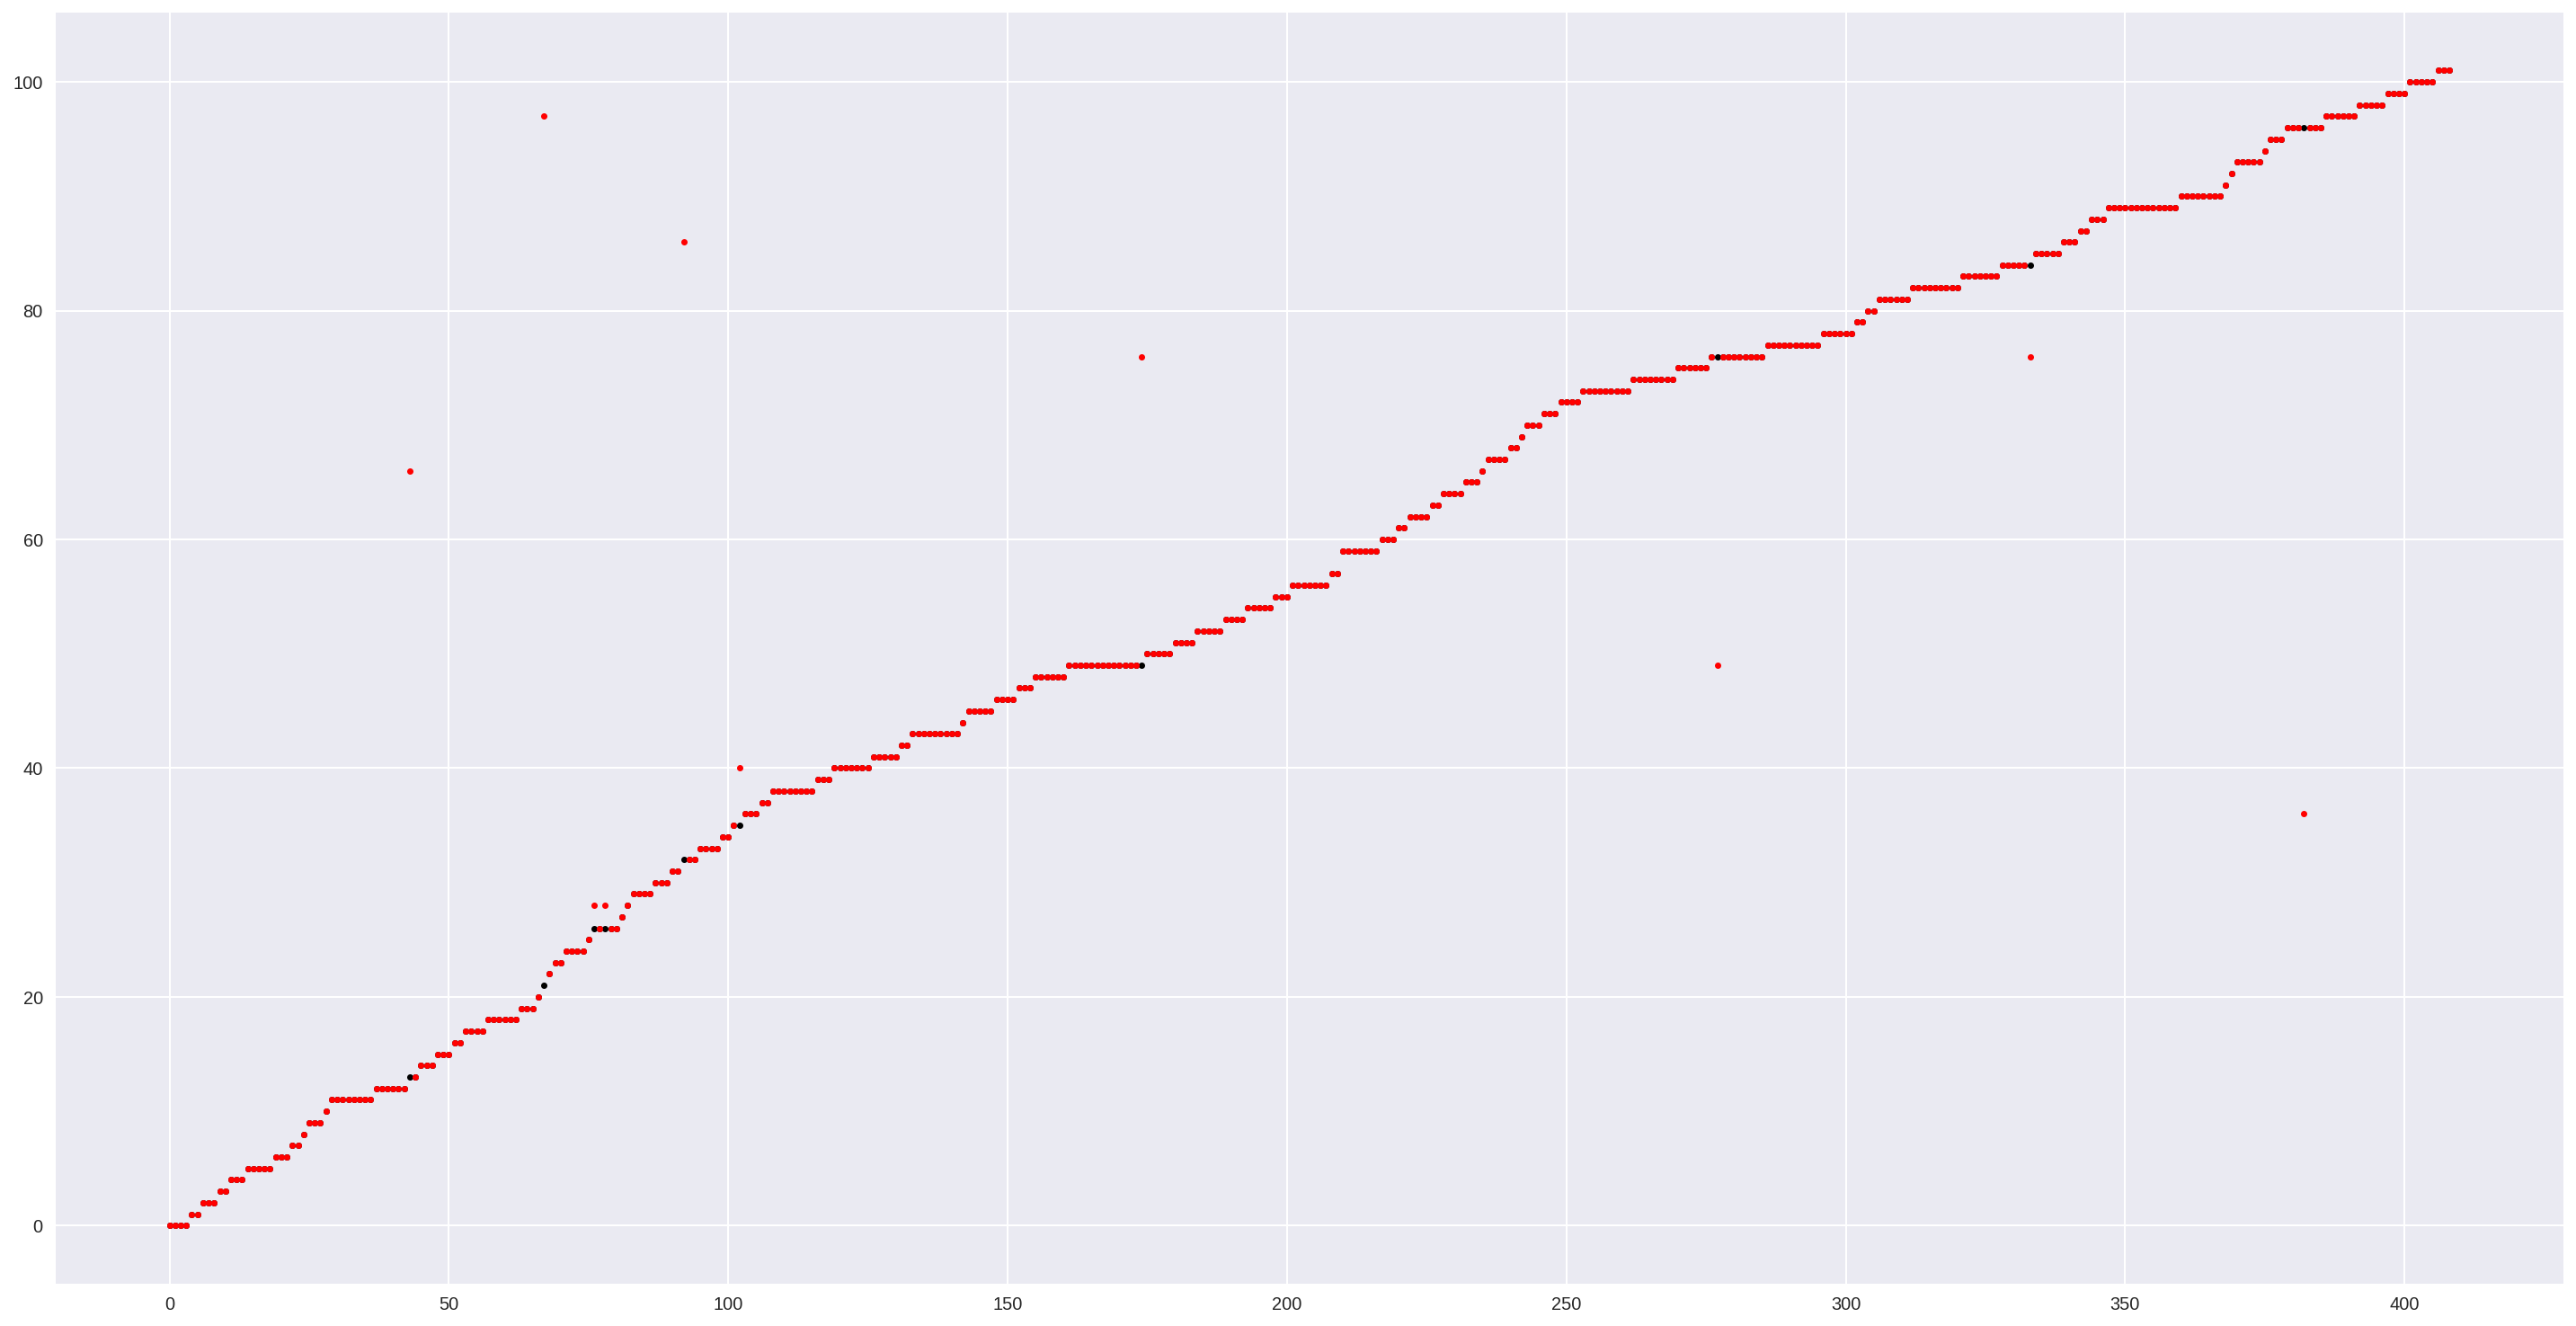

In [35]:
model = load_checkpoint()
device = 'cpu'

model.to(device)

test_model(show_graphs=True)

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [0]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='https://github.com/silviomori/udacity_deep_learning_pytorch_challenge/blob/master/assets/inference_example.png?raw=1' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [0]:
# TODO: Display an image along with the top 5 classes